<h1>
<center>
Dataquest Guided Project 9:
Analyzing CIA Factbook Data using SQLite and Python 
</center>
</h1>

## Introduction

This is part of the Dataquest program.

- part of paths **Data Analyst in Python & Data Scientist in Python**
    - Step 4: **Working with data sources**
        - Course 1 : **SQL Fundamentals **
            - SQL basics 
            - Summary statistics
            - Group summary statistics
            - Subqueries
            - Querying SQLite from Python

As this is a guided project, we are following and deepening the steps suggested by Dataquest. In this project, we'll explore the Python SQLite workflow to explore, analyze, and visualize data from a database.

## Use case : CIA World Factbook

In this project, we'll work with data from the [CIA World Facbook](https://www.cia.gov/library/publications/the-world-factbook/), a compendium of statistics about all of the countries on Earth. The Factbook contains demographic information like : 


| Header | Definition   |
|------|------|
|   **name** |  The name of the country|
|   **area**  | The total land and sea area of the country|
|   **population**  | The country's population |
|   **population_growth**  | The country's population growth as a percentage |
|   **birth_rate**  | The country's birt rate, or the number of births a year per 1,000 people|
|   **death_rate**  | The country's death rate, or the number of deaths a year per 1,000 people |
|   **area**  | The country's total area (both land and water) |
|   **area_land**  | The country's land area in square kilometers |
|   **area_water**  | The country's waterarea in square kilometers |

We will download the SQLite database from [from this GitHub repo](https://github.com/factbook/factbook.sql/releases) to work with it. 

## Load database and prepare data

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette('husl')
sns.set_style('white')

In [2]:
conn = sqlite3.connect("factbook.db")

Return the first 5 rows of the facts table in the database to know more about its structure:

In [3]:
q = "SELECT * FROM facts LIMIT 5"
pd.read_sql_query(q, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51,2015-11-01 13:19:49.461734,2015-11-01 13:19:49.461734
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30,2015-11-01 13:19:54.431082,2015-11-01 13:19:54.431082
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92,2015-11-01 13:19:59.961286,2015-11-01 13:19:59.961286
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00,2015-11-01 13:20:03.659945,2015-11-01 13:20:03.659945
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46,2015-11-01 13:20:08.625072,2015-11-01 13:20:08.625072


## Summary Statistics

Let's start by calculating some summary statistics and look for any outlier countries. We want to know the minimum and maximum population and population growth: 

In [4]:
pop_query = "SELECT MIN(population) as min_pop, MAX(population) as max_pop, MIN(population_growth) as min_pop_growth, MAX(population_growth) as max_pop_growth FROM facts"
pd.read_sql_query(pop_query, conn)

,min_pop,max_pop,min_pop_growth,max_pop_growth
0,0,7256490011,0.0,4.02


Let's find the countries with these values : 

In [5]:
out_query = 'SELECT * FROM facts WHERE population== (SELECT MIN(population) FROM facts) '
pd.read_sql_query(out_query, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,250,ay,Antarctica,None,280000,None,0,None,None,None,None,2015-11-01 13:38:44.885746,2015-11-01 13:38:44.885746


Antartica doesn't have any inhabitants. 

In [6]:
out_query = 'SELECT * FROM facts WHERE population== (SELECT MAX(population) FROM facts) '
pd.read_sql_query(out_query, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None,2015-11-01 13:39:09.910721,2015-11-01 13:39:09.910721


World is referenced as a country. We won't include it in the study.

## Histograms

Let's move on to generating histograms for the rest of the countries in the table, ignoring the whole world and Antartica rows. 
To have an overview of the data, we'll generate a 2 by 2 grid histograms for the population, population_growth, birth_rate and death_rate columns. 

In [7]:
query_hist = '''
SELECT population, population_growth, birth_rate, death_rate FROM facts
WHERE population != (SELECT MAX(population) FROM facts)
AND population != (SELECT MIN(population) FROM facts)'''

data_hist = pd.read_sql_query(query_hist, conn)

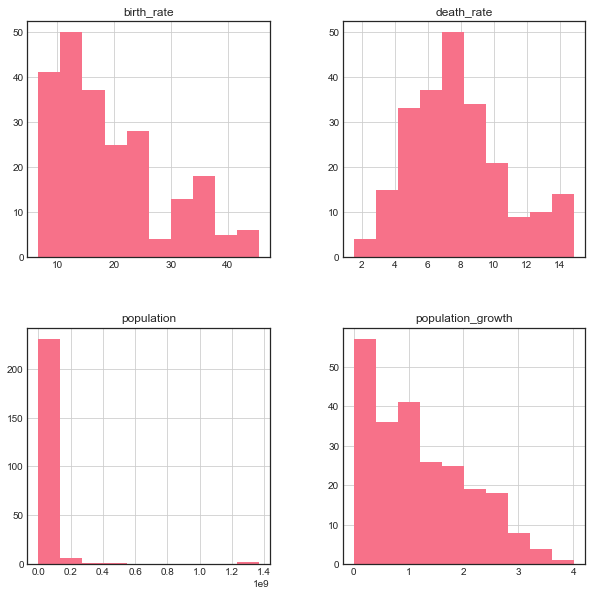

In [8]:
data_hist.hist(figsize=(10,10));

There are some outliers in the population distribution, making it hard to analyze without more data cleaning.
We can see that birth rate and population growth as a close tendency, which makes sense as they are correlated. Death rate seem to fit a gaussian distribution. 

## Which countries have the highest population density?

Let's go deeper and identify the countries with the highest population density.

In [9]:
density_query = '''
SELECT name, CAST(population as float) / CAST(area as float) density FROM facts
ORDER BY density DESC;'''

densities = pd.read_sql_query(density_query, conn)
densities.head(20)

,name,density
0,Macau,21168.964286
1,Monaco,15267.500000
2,Singapore,8141.279770
3,Hong Kong,6445.041516
4,Gaza Strip,5191.819444
5,Gibraltar,4876.333333
6,Bahrain,1771.859211
7,Maldives,1319.640940
8,Malta,1310.015823
9,Bermuda,1299.925926


Macau has the highest population density. This result is consistant with the one showed [in the Wikipedia page](https://simple.wikipedia.org/wiki/List_of_countries_by_population_density). 
We can notice than the top 5 has a tremendous population density compared to the rest of the countries. Let's confirm that by plotting the histogram of population density.

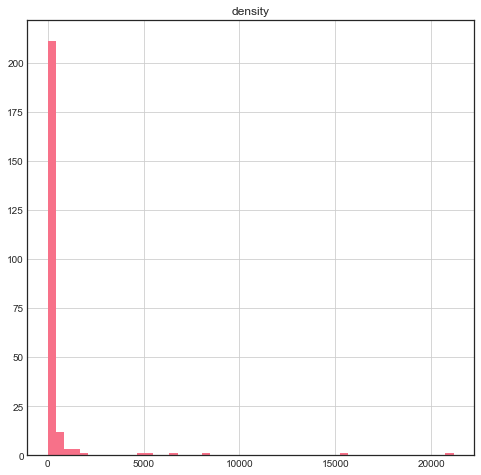

In [10]:
densities.hist(bins=50, figsize=(8,8));

We notice that the highest density countries listed previously are exceptions: population density is concentrated between 0 and less than 1000, which is far from the highest results around 21 000!  Let's plot the same histogram without the 10 top population density countries.

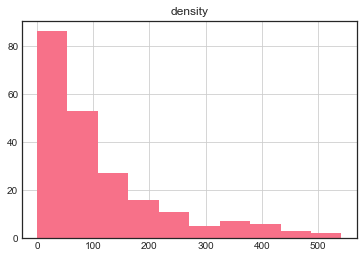

In [11]:
densities[20:].hist();

We also notice that a moajority of countries seem to have a very low density population. 

## Which countries have the highest ratios of water to land? 

In [12]:
water_query = '''
SELECT name, CAST(area_water AS Float) / CAST(area_land AS Float) AS water_ratio
FROM facts
ORDER BY water_ratio DESC'''
water_ratio = pd.read_sql_query(water_query, conn)

In [13]:
water_ratio.head(10)

,name,water_ratio
0,British Indian Ocean Territory,905.666667
1,Virgin Islands,4.520231
2,Puerto Rico,0.554791
3,"Bahamas, The",0.386613
4,Guinea-Bissau,0.284673
5,Malawi,0.259396
6,Netherlands,0.225710
7,Uganda,0.222922
8,Eritrea,0.164356
9,Liberia,0.156240


British Indian Ocean Territory is an English territory composed of mostly water areas. The small islands are military territories ([source](https://en.wikipedia.org/wiki/British_Indian_Ocean_Territory)). 
The Virgin Islands is not a country too, but a group of islands into three different political jurisdictions: American, English and Spanish ([source](https://en.wikipedia.org/wiki/Virgin_Islands)). 
Both of them have more water than land. 

Puerto Rico is an American territory, and The Bahamas is an English territory. 
Thus, the 2 countries with the highest ratio of water to land are Guinea-Bissau, Malawi.